In [1]:
# Import libraries

from sklearn.linear_model import LinearRegression
from shapely import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Load data

shapefile = gpd.read_file("./Shapefiles/Breda.shp")

income = pd.read_csv("./Datasets/Income.csv")
# Create a key to translate income values to income brackets
incomekey = {1: "€21,100 to €30,300", 2: "€30,300 to €42,800", 3: "€42,800 to €59,800", 4: "€59,800 +"}

data = pd.read_csv("./Datasets/Green.csv")
data = data.drop(columns = ["Year", "Image ID", "Date", "CBS Grid Code"])

In [3]:
# Define functions

# Identify the neighborhood coordinates belong to
def identify_neighborhood(lon, lat):
    # Convert coordinates to a point
    location = Point(lon, lat)
    try:
        # Locate the feature containing the point, and return its name
        return shapefile.loc[shapefile.geometry.contains(location), "BUURT"].iloc[0]
    except:
        return None

In [4]:
# Pre-process the data

# Change "Longitude" and "Latitude" delimiters
tqdm.pandas(desc = "Splitting coordinates...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: x.str.split(","))

# Convert "Longitude" and "Latitude" to numeric
tqdm.pandas(desc = "Converting to numeric...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: pd.to_numeric(x.str[0] + "." + x.str[1]))

# Create "Neighborhood" column and populate with neighborhood names
tqdm.pandas(desc = "Identifying neighborhoods...")
data["Neighborhood"] = data.progress_apply(lambda row: identify_neighborhood(row["Longitude"], row["Latitude"]), axis = 1)

# Create merged DataFrame
merged = data.merge(income, on = "Neighborhood", how = "left")
merged = merged.drop(columns = ["Latitude", "Longitude"])

# Create new columns with merged data 
merged["Average Green Score"] = merged.groupby("Neighborhood")["Green Score"].transform("mean")
merged["Average Income"] = merged["Income Index"].map(incomekey)

# Drop unnecessary columns and duplicate rows
merged = merged.drop(columns = ["Green Score"])
merged = merged.drop_duplicates()

# Export merged DataFrame
merged.to_csv("./Datasets/Merged.csv", index = False)

# Create geodata
geodata = shapefile.merge(merged, left_on = "BUURT", right_on = "Neighborhood", how = "left")

# Linear regression
regression_model = LinearRegression()
merged = merged.dropna(subset = ["Average Income", "Average Green Score"], how = "any")
X = merged["Income Index"].dropna().values.reshape(-1, 1)
y = merged["Average Green Score"].dropna().values.reshape(-1, 1)
regression_model.fit(X, y)
predicted_scores = regression_model.predict(X)

Identifying neighborhoods...: 100%|██████████| 298038/298038 [00:29<00:00, 10149.57it/s]


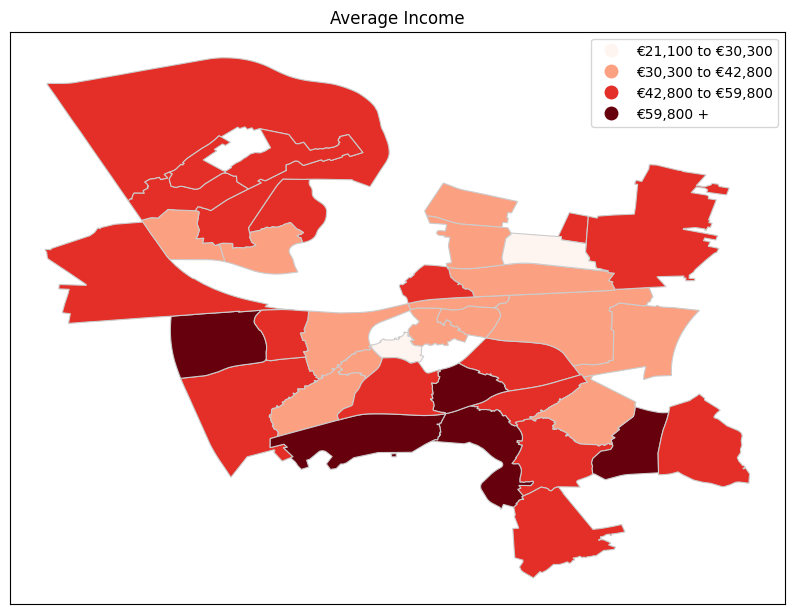

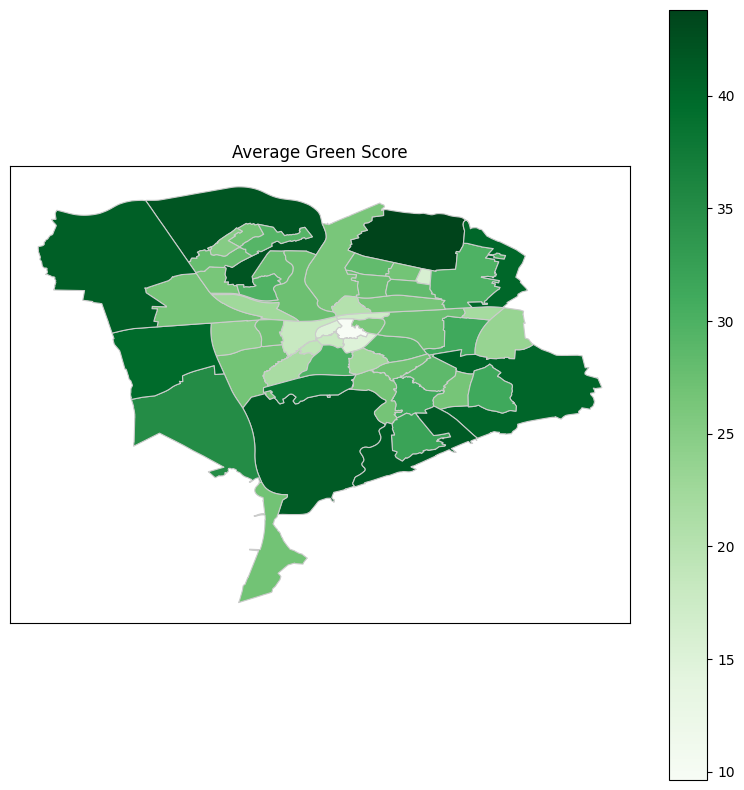

AttributeError: PathCollection.set() got an unexpected keyword argument 'outlier_mask'

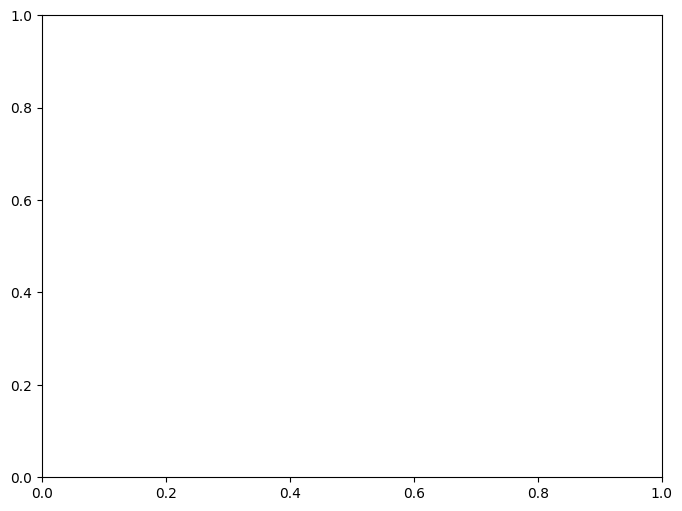

In [5]:
# Display "Average Income" by neighborhood in a chloropleth map plot

# Configure plot parameters
fig, ax1 = plt.subplots(figsize=(10, 10))

geodata.plot(
    column = "Average Income",
    cmap = "Reds", linewidth = 0.8,
    ax = ax1,
    edgecolor = "0.8",
    legend = True)

# Remove axes and labels
ax1.set_xticks([])
ax1.set_yticks([])

# Display the plot
plt.title("Average Income")
plt.show()

# Display "Average Green Score" in a chloropleth map

# Configure plot parameters
fig, ax2 = plt.subplots(figsize = (10, 10))

geodata.plot(
    column = "Average Green Score",
    cmap = "Greens",
    linewidth = 0.8,
    ax = ax2,
    edgecolor = "0.8",
    legend = True)

# Remove axis ticks
ax2.set_xticks([])
ax2.set_yticks([])

# Convert y-axis values to percentages
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(decimals = 0))

# Display the plot
plt.title("Average Green Score")
plt.show()

# Calculate the correlation between "Income Index" and "Average Green Score"
correlation = geodata["Income Index"].corr(geodata["Average Green Score"])

# Display the correlation in a scatter plot

fig, ax = plt.subplots(figsize = (8, 6))

sns.scatterplot(
    data = geodata,
    x = "Income Index",
    y = "Average Green Score",
    ax = ax,
    outlier_mask = (geodata["Average Green Score"] < geodata["Average Green Score"].quantile(0.95)))

plt.plot(
    X,
    predicted_scores,
    color = "r",
    linewidth = 2,
    label = "Regression Line")

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Convert x-axis income values to income brackets
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer = True))
ax.set_xticklabels([incomekey.get(int(x), x) for x in ax.get_xticks()])

# Convert y-axis values to percentages
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals = 0))

# Display the plot with correlation
ax.set_title(f"Correlation: {correlation:.2f}")
plt.show()